In [79]:
import os
import keras
from keras.applications import inception_v3 as inc_net
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
print('Notebook run using keras:', keras.__version__)
K.set_learning_phase(0)

Notebook run using keras: 2.0.9


In [80]:
import h5py as h5py

In [81]:
inet_model = inc_net.InceptionV3()

In [82]:
def transform_img_fn(path_list):
    out = []
    for img_path in path_list:
        img = image.load_img(img_path, target_size=(299, 299))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = inc_net.preprocess_input(x)
        out.append(x)
    return np.vstack(out)

[('n03461385', 'grocery_store', 0.7624492), ('n02823428', 'beer_bottle', 0.052200008), ('n04591713', 'wine_bottle', 0.026117222), ('n03983396', 'pop_bottle', 0.014479523), ('n04204238', 'shopping_basket', 0.0085189268)]


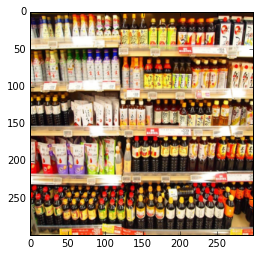

In [83]:
images = transform_img_fn(["./suupa.jpg"])
# I'm dividing by 2 and adding 0.5 because of how this Inception represents images
plt.imshow(images[0] / 2 + 0.5)
preds = inet_model.predict(images)
for x in decode_predictions(preds):
    print(x)

In [84]:
%load_ext autoreload
%autoreload 2
import os,sys
try:
    import lime
except:
    sys.path.append(os.path.join('..', '..')) # add the current directory
    import lime
from lime import lime_image

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Generate an adversarial example

In [85]:
import foolbox
import keras
import numpy as np

# instantiate model
kmodel = inet_model
preprocessing = (np.array([104, 116, 123]), 1)
fmodel = foolbox.models.KerasModel(kmodel, bounds=(-1, 1), preprocessing=preprocessing)

In [77]:
img = transform_img_fn(["./suupa.jpg"])[0]

In [78]:
# apply attack on source image
criterion = foolbox.criteria.TargetClass(22)
attack = foolbox.attacks.FGSM(fmodel, criterion)
label = 582
adversarial = attack(img[:,:,::-1], label)

/usr/local/lib/python3.6/site-packages/foolbox/attacks/base.py:99: UserWarning: GradientSignAttack did not find an adversarial, maybe the model or the criterion is not supported by this attack.
  warnings.warn('{} did not find an adversarial, maybe the model or the criterion is not supported by this attack.'.format(self.name()))  # noqa: E501


[('n03461385', 'grocery_store', 0.7624492), ('n02823428', 'beer_bottle', 0.052200008), ('n04591713', 'wine_bottle', 0.026117222), ('n03983396', 'pop_bottle', 0.014479523), ('n04204238', 'shopping_basket', 0.0085189268)]


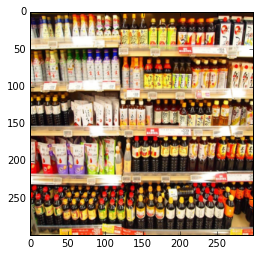

In [60]:
# I'm dividing by 2 and adding 0.5 because of how this Inception represents images
plt.imshow(img / 2 + 0.5)
preds = inet_model.predict(np.expand_dims(img, axis=0))
for x in decode_predictions(preds):
    print(x)

[('n03983396', 'pop_bottle', 0.17644878), ('n03916031', 'perfume', 0.17114092), ('n02823428', 'beer_bottle', 0.078851536), ('n04557648', 'water_bottle', 0.076398969), ('n03461385', 'grocery_store', 0.032211259)]


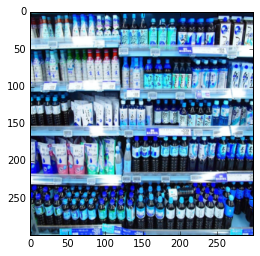

In [61]:
# I'm dividing by 2 and adding 0.5 because of how this Inception represents images
plt.imshow(adversarial / 2 + 0.5)
preds = inet_model.predict(np.expand_dims(adversarial, axis=0))
for x in decode_predictions(preds):
    print(x)

## Lime

In [50]:
explainer = lime_image.LimeImageExplainer()

Number to label: https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a

In [75]:
explanation_img = explainer.explain_instance(img, inet_model.predict, top_labels=5, hide_color=0, num_samples=200)



In [62]:
%%time
# Hide color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels
explanation = explainer.explain_instance(adversarial, inet_model.predict, top_labels=5, hide_color=0, num_samples=200)

CPU times: user 4min 12s, sys: 20.3 s, total: 4min 32s
Wall time: 1min 21s


In [63]:
from skimage.segmentation import mark_boundaries

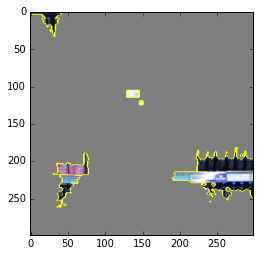

In [70]:
temp, mask = explanation.get_image_and_mask(737, positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

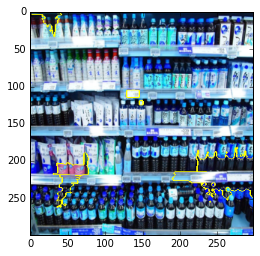

In [71]:
temp, mask = explanation.get_image_and_mask(737, positive_only=True, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

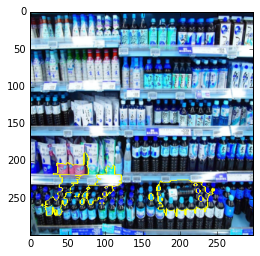

In [73]:
temp, mask = explanation.get_image_and_mask(582, positive_only=True, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))